# **Streaming Platform Exclusive Content Analysis**

This notebook analyzes exclusive vs. non-exclusive TV content across major streaming services (Netflix, Hulu, Amazon Prime, Disney+, HBO Max). It explores platform strategy through genre, rating, tag distribution, and unsupervised tag clustering.

---

## **Project Goals**

1. **What type of content is most sought after by platforms?**  
   → Exclusive content reveals what platforms prioritize and invest in.

2. **What content are platforms likely to acquire or support?**  
   → Platform-exclusive patterns guide acquisition strategy and potential production alignment.

3. **What types of shows succeed on these platforms?**  
   → High-rated, long-running exclusives reveal content that resonates with users.

---

## **Section Overview**

### 1. **Data Ingestion & Filtering**
- Loads TV show data from ReelGood.
- Filters to TV shows only.
- Retains top 5 streaming platforms.
- Fills missing age/rating fields via mapping.
- Splits content into exclusive and non-exclusive sets.

### 2. **Genre Distribution & Rating Analysis**
- Drops duplicate show titles.
- Compares mean IMDB ratings across genres and platforms.
- Aggregates show-level info (e.g., average ratings, number of seasons).
- Prepares clean `top_rated` dataset for tag analysis.

### 3. **Tag Clustering (BERT + KMeans)**
- Uses Sentence-BERT to embed tag descriptions.
- Clusters tags using KMeans (k=30 and k=40).
- Maps clustered tags back to shows.
- Visualizes tag clusters using t-SNE.
- Builds tag cluster-to-label mappings.

### 4. **Content Tag Insights by Platform**
- Explores dominant content themes by platform (via tag cluster labels).
- Creates bar plots for exclusive and overall content.
- Normalizes tag cluster distributions across services.

---

## **Notes**
- All platform-specific content is filtered for exclusivity using the `"Exclusive Service"` column.
- Tag embeddings and clustering are based on Sentence-BERT (`all-MiniLM-L6-v2`) and `KMeans`.
- Genre and tag analysis are done on the title level (one row per show).


# **Data Ingestion & Filtering**

**Purpose:**
- Load streaming content data from ReelGood.
- Filter to TV shows only.
- Standardize service names and retain major streaming platforms.
- Fill missing rating fields using mapping between 'Rated' and 'AgeRating'.
- Subset data into exclusive vs. non-exclusive content per platform.

In [97]:
# -- Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -- Mount Drive & Load Dataset
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv("/content/drive/MyDrive/574 Assignment 3/Assignment Data/Streaming Assignment/ReelGood Data/Reel Good Data (Title+Service+Genre+Tag List).csv", index_col=0)

# -- Quick Checks
df['Genre'].nunique()

# ============================================
# Filter TV Shows Only
# ============================================
df = df[df['Type'] == 'tv']
df

df['Service'].value_counts().head(20)

# ============================================
# Create Target Service Flag (1 = major streamer)
# ============================================
df_copy = df.copy()

target_services = ['netflix', 'hulu_plus', 'amazon_prime', 'hbo_max', 'disney_plus']

df_copy['target_service'] = 0
df_copy.loc[df_copy['Service'].str.lower().isin(target_services), 'target_service'] = 1

df_copy['target_service'].value_counts(normalize=True)
df_copy[df_copy['target_service'] == 1]['Service'].value_counts(normalize=True) * 100

# ============================================
# Fill Missing Ratings via AgeRating Mapping
# ============================================
age_to_rated_map = {
    '7+': 'TV-G',
    '13+': 'TV-PG',
    '16+': 'TV-14',
    '18+': 'TV-MA',
    'all': 'TV-G'  # fallback
}

df['Rated_filled'] = df['Rated'].fillna(
    df['AgeRating'].map(age_to_rated_map)
)

rated_to_age_map = {
    'TV-G': '7+',
    'TV-PG': '13+',
    'TV-14': '16+',
    'TV-MA': '18+'
}

df['AgeRating_filled'] = df['AgeRating'].fillna(
    df['Rated'].map(rated_to_age_map)
)

# ============================================
# Filter to Major Services
# ============================================
service_list = ['netflix','hulu_plus','amazon_prime','hbo_max','disney_plus']
df = df[df['Service'].isin(service_list)]

df1 = df.copy()

df['Service'].value_counts()

# ============================================
# Split into Exclusive vs Non-Exclusive
# ============================================
exclusive_df = df[df['Exclusive Service'] == 1]

exclusive_netflix = exclusive_df[exclusive_df['Service'] == 'netflix']
exclusive_hulu = exclusive_df[exclusive_df['Service'] == 'hulu_plus']
exclusive_amazon = exclusive_df[exclusive_df['Service'] == 'amazon_prime']
exclusive_hbo = exclusive_df[exclusive_df['Service'] == 'hbo_max']
exclusive_disney = exclusive_df[exclusive_df['Service'] == 'disney_plus']

nonexclusive_df = df[df['Exclusive Service'] == 0]

nonexclusive_netflix = nonexclusive_df[nonexclusive_df['Service'] == 'netflix']
nonexclusive_hulu = nonexclusive_df[nonexclusive_df['Service'] == 'hulu_plus']
nonexclusive_amazon = nonexclusive_df[nonexclusive_df['Service'] == 'amazon_prime']
nonexclusive_hbo = nonexclusive_df[nonexclusive_df['Service'] == 'hbo_max']
nonexclusive_disney = nonexclusive_df[nonexclusive_df['Service'] == 'disney_plus']


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/tmp/ipython-input-97-1084342442.py:11: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/drive/MyDrive/574 Assignment 3/Assignment Data/Streaming Assignment/ReelGood Data/Reel Good Data (Title+Service+Genre+Tag List).csv", index_col=0)
/tmp/ipython-input-97-1084342442.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Rated_filled'] = df['Rated'].fillna(
/tmp/ipython-input-97-1084342442.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

## **Genre Distribution & Rating Analysis**

In [98]:
# --------------------------------------------
# Exclusive Titles: Preview + Deduplication
# --------------------------------------------

exclusive_df.head()

# Drop duplicate titles to get one row per show
exclusive_ratings = exclusive_df.drop_duplicates(subset=['Title'])
nonexclusive_ratings = nonexclusive_df.drop_duplicates(subset=['Title'])

exclusive_ratings.head()

# --------------------------------------------
# Mean IMDB Ratings by Service & Genre
# --------------------------------------------

# Pivot tables showing average IMDB scores per genre per service
exclusive_ratings.groupby(['Service','Genre'])['IMDB'].mean().unstack()
nonexclusive_ratings.groupby(['Service','Genre'])['IMDB'].mean().unstack()

# ============================================
# HIGH RATINGS & SEASONALITY ANALYSIS
# ============================================

# Use full df1 (filtered earlier) to build an aggregated view
df1

# --------------------------------------------
# Aggregate Show-Level Info (One Row per Title)
# --------------------------------------------
agg_df = df1.groupby('Title').agg({
    'IMDB': 'mean',                     # or max, or first
    'ReelGood': 'mean',
    'Seasons': 'max',
    'Genre': lambda x: list(set(x)),    # All genres for the show
    'Tag': lambda x: list(set().union(*x)) if isinstance(x.iloc[0], list) else x.mode(),  # Clean tag aggregation
    'Service': lambda x: list(set(x)),  # All services it appears on
    'Exclusive Service': 'max'          # 1 = exclusive on at least one service
}).reset_index()

# --------------------------------------------
# Prep for Further Analysis
# --------------------------------------------
agg_df['Service'].value_counts()  # Distribution check

top_rated = agg_df.copy()
top_rated.drop(columns='ReelGood', inplace=True)  # Drop for now (optional)

top_rated.sample(5)  # Quick peek at cleaned top-rated dataset

,Title,IMDB,Seasons,Genre,Tag,Service,Exclusive Service
4606,Wiseguy,7.8,4.0,"[Action & Adventure, Crime, Drama]","['Gangster', 'Gangster', 'Gangster', 'Gangster...",[hulu_plus],0
1051,Dino Girl Gauko,6.9,NaN,"[Family, Children, Animation]",[nan],[netflix],1
900,Culture in Decline,8.4,NaN,[Documentary],"[nan, nan, nan]",[amazon_prime],0
2926,Public Enemies,7.1,1.0,"[Crime, Drama]",['Female Director'],[amazon_prime],1
2099,Land of the Lost,6.9,2.0,"[Family, Comedy, Action & Adventure]",['Time Travel'],[amazon_prime],0


# **Tag Clustering & Analysis**

Batches:   0%|          | 0/41 [00:00<?, ?it/s]

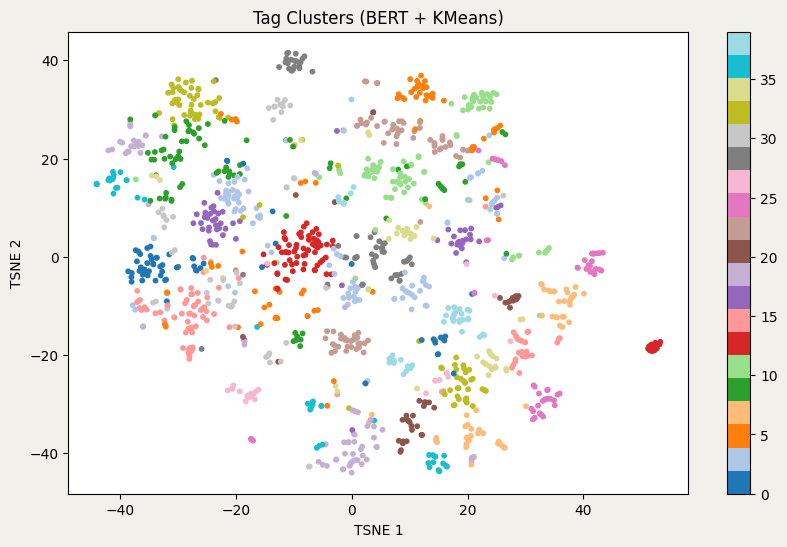

Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Cluster 0: ["['Dog', 'Cartoon']", "['Fashion']", "['Comic Book']", "['Cartoon', 'Cartoon']", "['Cartoon', 'Comic Book', 'Adaptation', 'Cartoon', 'Comic Book', 'Adaptation', 'Cartoon', 'Comic Book', 'Adaptation', 'Cartoon', 'Comic Book', 'Adaptation']", "['Cartoon', 'Animal']", "['Cartoon', 'Cartoon', 'Cartoon', 'Cartoon']", "['Cartoon']", "['Genius']", "['Cartoon', 'Animal', 'Cartoon', 'Animal', 'Cartoon', 'Animal']"]
Cluster 1: ["['Serial Killer', 'Doctor', 'Vampire', 'Religion', 'Ghost', 'Supernatural', 'Time Travel', 'Serial Killer', 'Doctor', 'Vampire', 'Religion', 'Ghost', 'Supernatural', 'Time Travel', 'Serial Killer', 'Doctor', 'Vampire', 'Religion', 'Ghost', 'Supernatural', 'Time Travel']", "['War', 'Fighting', 'Monster', 'Vampire', 'Religion', 'Supernatural', 'War', 'Fighting', 'Monster', 'Vampire', 'Religion', 'Supernatural']", "['Vampire', 'Supernatural', 'Vampire', 'Supernatural']", "['Vampire', 'Supernatural']", "['Magic', 'Futuristic', 'Vampire', 'Supernatural', 'Based on

In [99]:
# ============================================
# TAG CLUSTERING & ANALYSIS
# ============================================

# --------------------------------------------
# Install Sentence-BERT
# --------------------------------------------
!pip install -U sentence-transformers

# --------------------------------------------
# Imports
# --------------------------------------------
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from collections import defaultdict

# --------------------------------------------
# STEP 1: Flatten & Clean Tag List
# --------------------------------------------
tag_series = top_rated['Tag'].explode()
tag_series = tag_series[tag_series.notnull() & tag_series.apply(lambda x: isinstance(x, str))]
tag_series_cleaned = tag_series.str.strip().unique()

# --------------------------------------------
# STEP 2: Encode Tags with Sentence-BERT
# --------------------------------------------
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(tag_series_cleaned, show_progress_bar=True)

# --------------------------------------------
# STEP 3: Cluster Tags via KMeans (k=40)
# --------------------------------------------
k = 40
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(embeddings)

# --------------------------------------------
# STEP 4: Build Mapping Dict
# --------------------------------------------
tag_cluster_df = pd.DataFrame({
    'Tag': tag_series_cleaned,
    'Cluster': clusters
})
tag_to_cluster = dict(zip(tag_cluster_df['Tag'], tag_cluster_df['Cluster']))

# --------------------------------------------
# STEP 5: Apply Cluster Labels to Shows
# --------------------------------------------
def map_tag_list(tag_list):
    if isinstance(tag_list, list):
        return [tag_to_cluster.get(tag.strip(), -1) for tag in tag_list if isinstance(tag, str)]
    return []

top_rated['Tag_Cluster'] = top_rated['Tag'].apply(map_tag_list)

# --------------------------------------------
# Visualize Tag Clusters via t-SNE
# --------------------------------------------
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(embeddings)

plt.figure(figsize=(10, 6))
plt.scatter(tsne_results[:,0], tsne_results[:,1], c=clusters, cmap='tab20', s=10)
plt.title('Tag Clusters (BERT + KMeans)')
plt.xlabel('TSNE 1')
plt.ylabel('TSNE 2')
plt.colorbar()

# Set background color (figure only)
fig = plt.gcf()
fig.patch.set_facecolor('#f1f0ea')

plt.show()

# --------------------------------------------
# Re-do Clustering with Flattened Tags (k=30)
# --------------------------------------------
flat_tags = top_rated['Tag'].explode()
flat_tags = flat_tags[flat_tags.notnull() & flat_tags.apply(lambda x: isinstance(x, str))].str.strip()
unique_tags = flat_tags.unique()

model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(unique_tags, show_progress_bar=True)

k = 30
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(embeddings)

tag_cluster_df = pd.DataFrame({'Tag': unique_tags, 'Cluster': clusters})

# --------------------------------------------
# Apply Clusters to Each Title
# --------------------------------------------
top_rated_expanded = top_rated.explode('Tag')
top_rated_expanded['Tag'] = top_rated_expanded['Tag'].astype(str).str.strip()

merged_df = top_rated_expanded.merge(tag_cluster_df, how='inner', on='Tag')
tag_cluster_grouped = merged_df.groupby('Title')['Cluster'].apply(list).reset_index()
tag_cluster_grouped.rename(columns={'Cluster': 'Tag_Clusters'}, inplace=True)

top_rated = top_rated.drop(columns=['Tag_Cluster'], errors='ignore')
top_rated = top_rated.merge(tag_cluster_grouped, how='left', on='Title')

# --------------------------------------------
# Quick Distribution Check
# --------------------------------------------
top_rated['Tag_Clusters'].value_counts().head()
top_rated[top_rated['Exclusive Service'] == 1]['Tag_Clusters'].value_counts().head()

# --------------------------------------------
# Print Sample Tags Per Cluster
# --------------------------------------------
cluster_to_tags = defaultdict(list)
for _, row in tag_cluster_df.iterrows():
    cluster_to_tags[row['Cluster']].append(row['Tag'])

for cluster_id in sorted(cluster_to_tags.keys()):
    print(f"Cluster {cluster_id}: {cluster_to_tags[cluster_id][:10]}")

# --------------------------------------------
# Add Human-Readable Cluster Labels
# --------------------------------------------
cluster_names = {
    0: "Cartoon & Comic Entertainment",
    1: "Dark Fantasy & Supernatural Horror",
    2: "Teen Sci-Fi & Magic Mix",
    3: "Science, Technology & Space",
    4: "Royal Fantasy & Magical Worlds",
    5: "Crime, Prison & Serial Killers",
    6: "Teen Life & Coming of Age",
    7: "Sports & Teen Competition",
    8: "Religion, Politics & Animals",
    9: "True Stories & Biopics",
    10: "War & Historical Conflict",
    11: "Drug, Gangster & Crime Underworld",
    12: "Missing / Unlabeled Data",
    13: "Dystopia, Apocalypse & Futuristic Struggles",
    14: "Supernatural Drama & Monster Themes",
    15: "Music, Singing & Friendship",
    16: "Superhero & Comic Book Action",
    17: "Doctor-Centric Stories & Genius Themes",
    18: "Book Adaptations & Literary Works",
    19: "Mature Drama & Crime",
    20: "Feel-Good & Friendship",
    21: "Video Games & Survival",
    22: "Martial Arts & Fantasy Action",
    23: "Political Espionage & Revenge",
    24: "New York Crime & Urban Life",
    25: "Cars, Racing & Holidays",
    26: "Disney Core Themes",
    27: "Disaster & Survival",
    28: "Parody & Dark Comedy",
    29: "Alien, Space & Time Travel"
}

cluster_name_df = pd.DataFrame(list(cluster_names.items()), columns=['Cluster', 'Cluster_Label'])
tag_cluster_df = tag_cluster_df.merge(cluster_name_df, on='Cluster', how='left')

def map_clusters_to_labels(cluster_list):
    if isinstance(cluster_list, list):
        return [cluster_names.get(c, 'Unknown') for c in cluster_list]
    return []

top_rated['Tag_Cluster_Labels'] = top_rated['Tag_Clusters'].apply(map_clusters_to_labels)

# **Content Tag Insights by Platform**

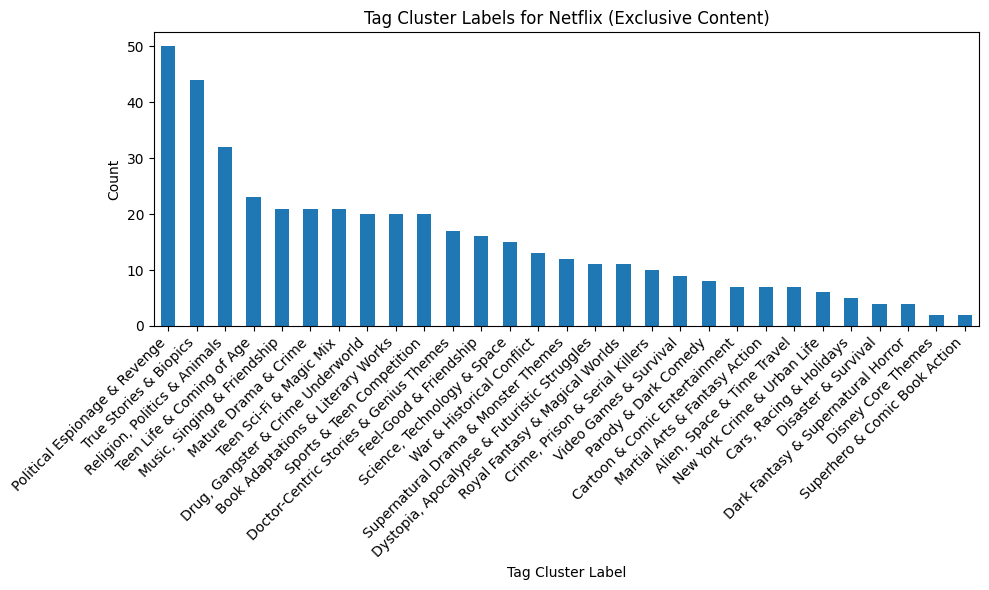

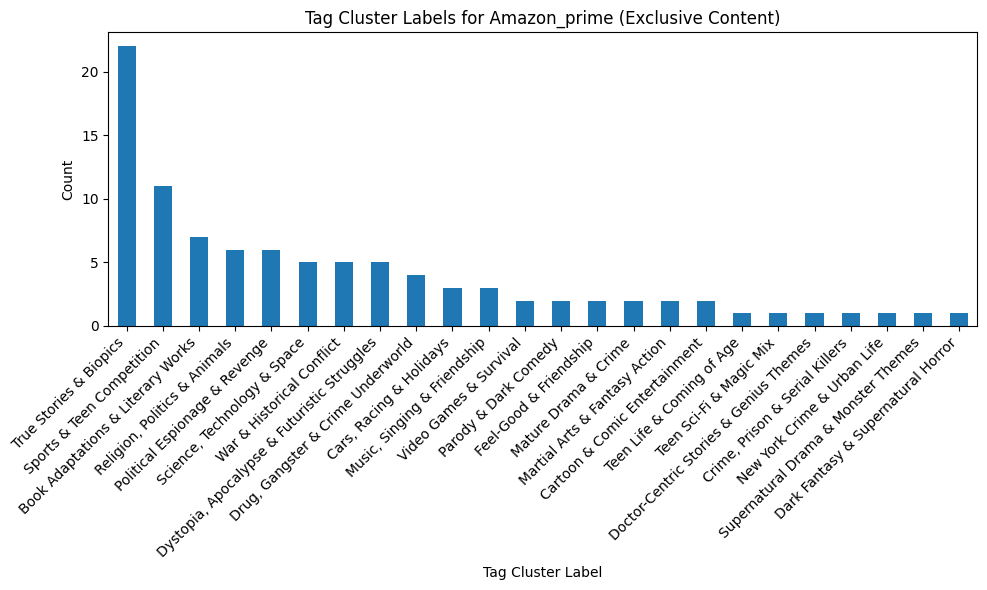

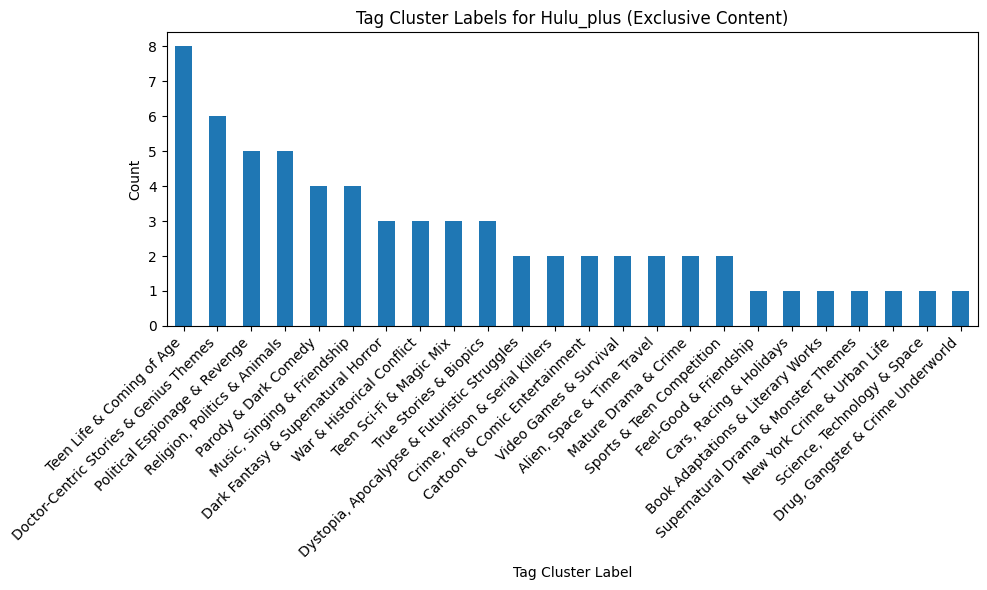

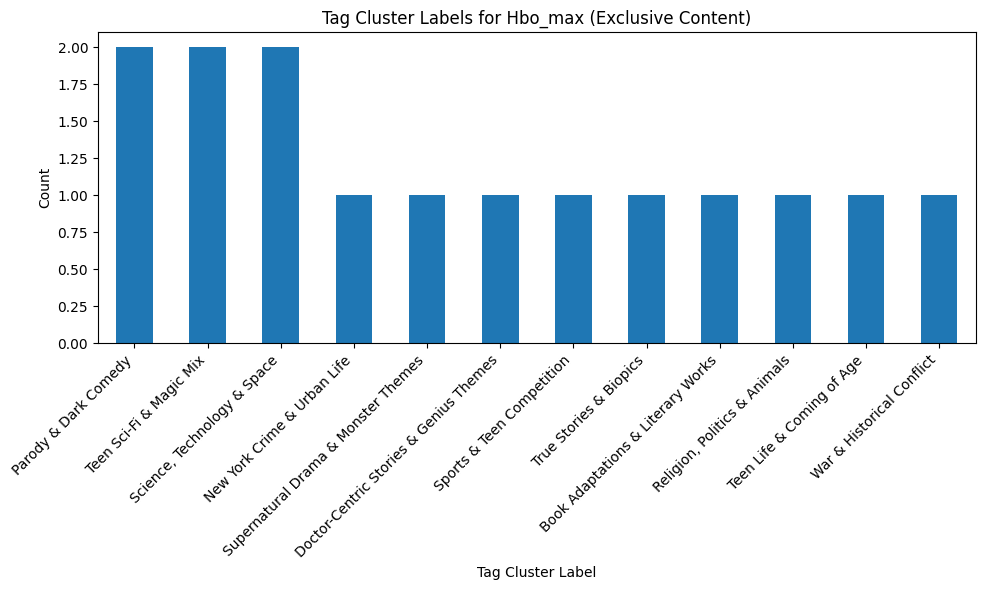

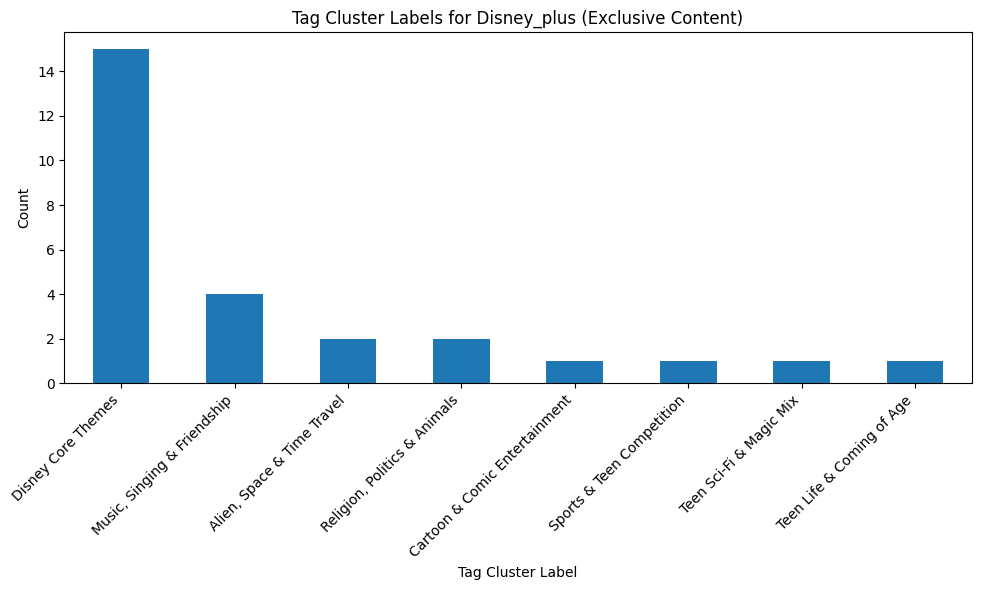

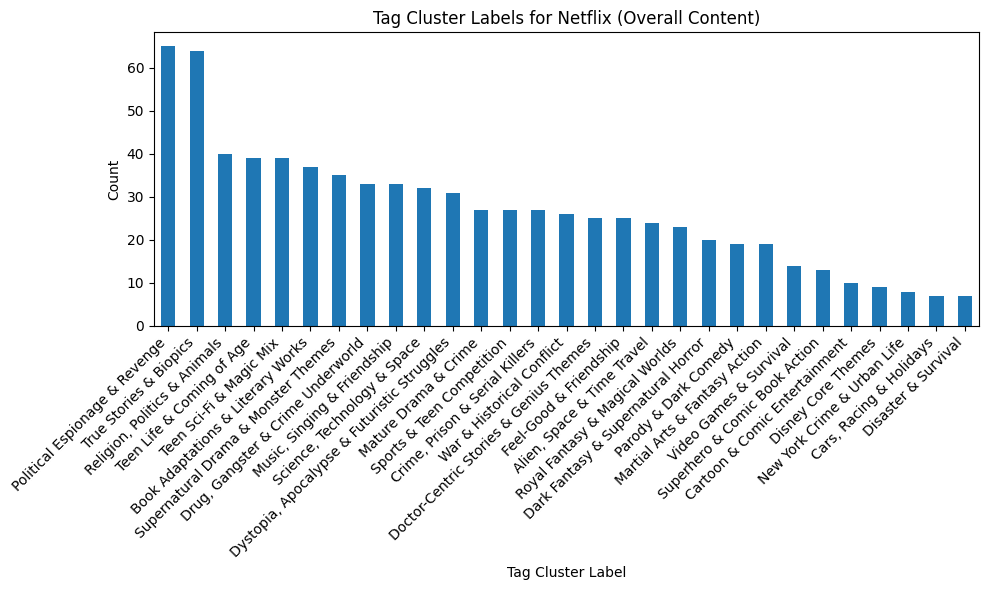

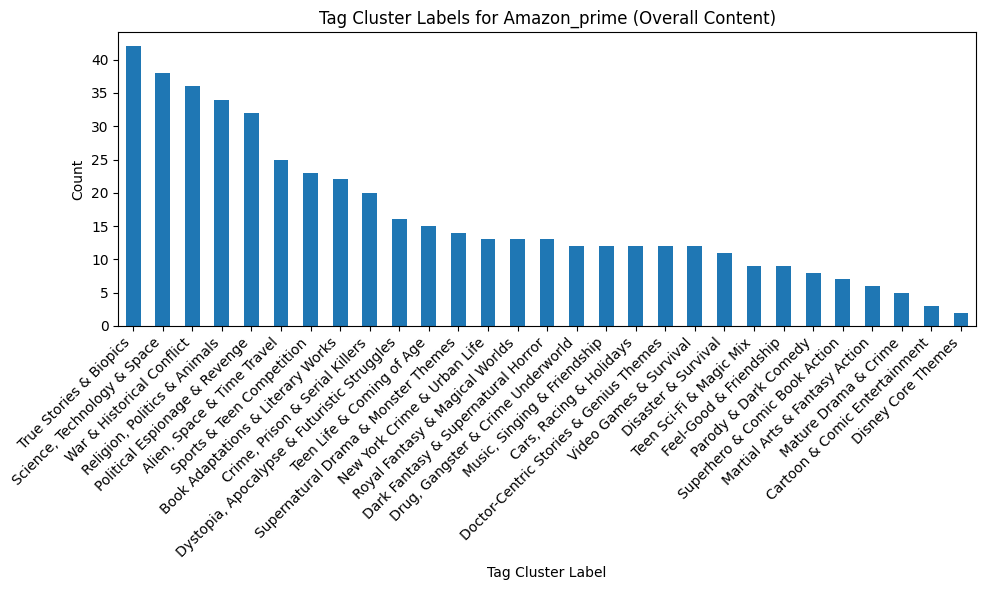

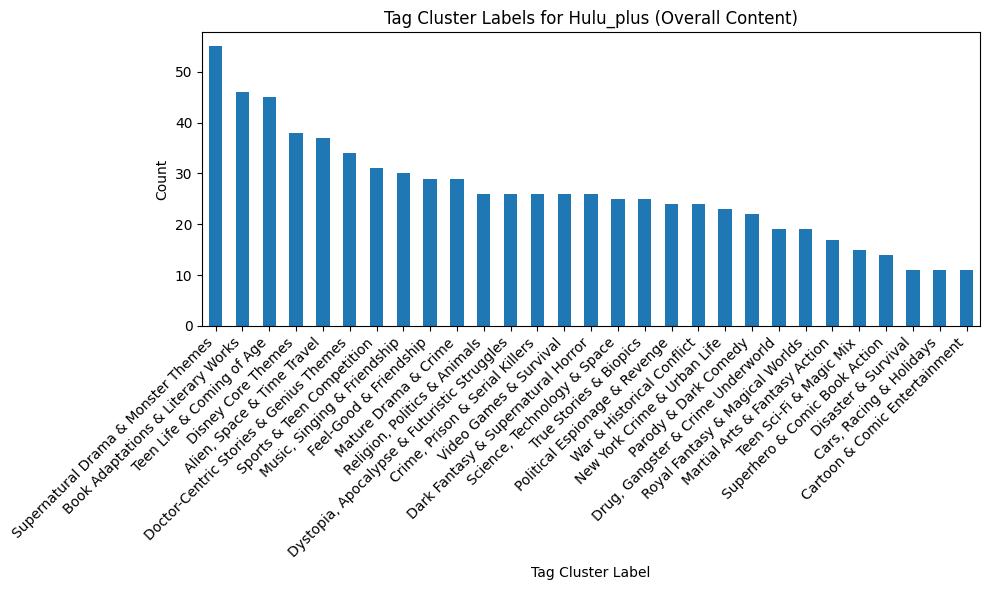

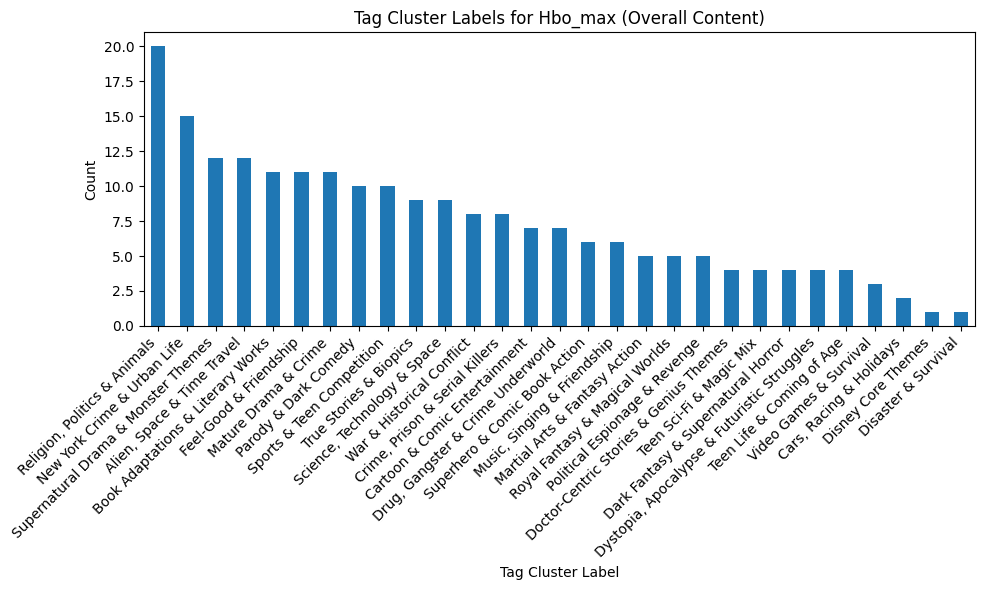

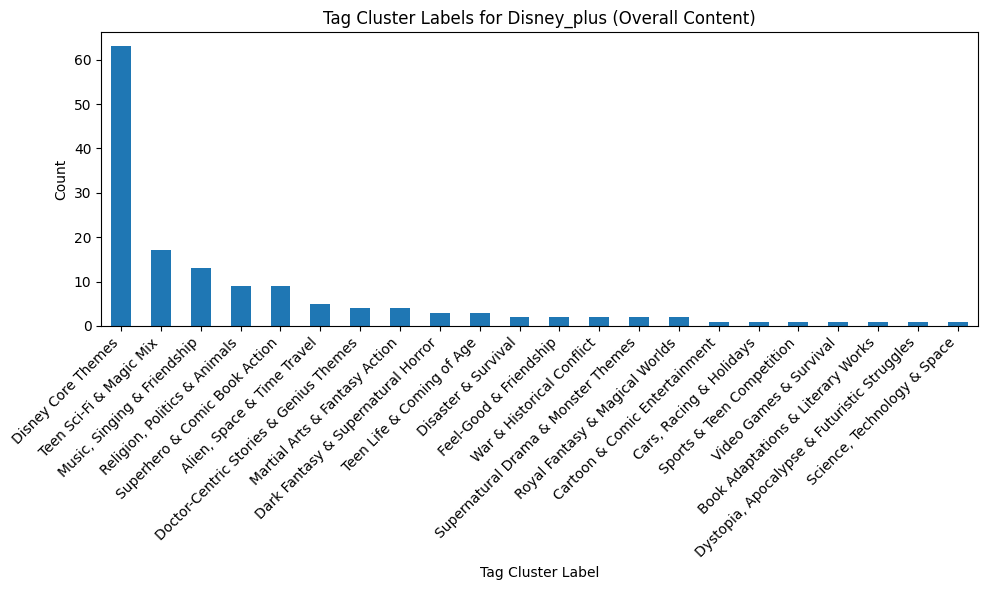

Service,amazon_prime,disney_plus,hbo_max,hulu_plus,netflix
Tag_Cluster_Labels,,,,,
"Alien, Space & Time Travel",0.00,4.0,0.00,0.92,0.59
Book Adaptations & Literary Works,2.41,0.0,1.49,0.46,1.68
"Cars, Racing & Holidays",1.03,0.0,0.00,0.46,0.42
Cartoon & Comic Entertainment,0.69,2.0,0.00,0.92,0.59
"Crime, Prison & Serial Killers",0.34,0.0,0.00,0.92,0.84
Dark Fantasy & Supernatural Horror,0.34,0.0,0.00,1.38,0.34
Disaster & Survival,0.00,0.0,0.00,0.00,0.34
Doctor-Centric Stories & Genius Themes,0.34,0.0,1.49,2.76,1.43
"Drug, Gangster & Crime Underworld",1.38,0.0,0.00,0.46,1.68


In [100]:
# ============================================
# BAR PLOTS: Cluster Label Distribution
# ============================================

services = ['netflix', 'amazon_prime', 'hulu_plus', 'hbo_max', 'disney_plus']

# -- Exclusive Content Tag Clusters
for service in services:
    service_df = top_rated[(top_rated['Service'].apply(lambda x: service in x)) & (top_rated['Exclusive Service'] == 1)]
    exploded_df = service_df.explode('Tag_Cluster_Labels')
    cleaned_df = exploded_df[exploded_df['Tag_Cluster_Labels'] != 'Missing / Unlabeled Data']
    value_counts = cleaned_df['Tag_Cluster_Labels'].value_counts()

    plt.figure(figsize=(10, 6))
    value_counts.plot(kind='bar')
    plt.title(f'Tag Cluster Labels for {service.capitalize()} (Exclusive Content)')
    plt.xlabel('Tag Cluster Label')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# -- Overall Content Tag Clusters
for service in services:
    service_df = top_rated[(top_rated['Service'].apply(lambda x: service in x))]
    exploded_df = service_df.explode('Tag_Cluster_Labels')
    cleaned_df = exploded_df[exploded_df['Tag_Cluster_Labels'] != 'Missing / Unlabeled Data']
    value_counts = cleaned_df['Tag_Cluster_Labels'].value_counts()

    plt.figure(figsize=(10, 6))
    value_counts.plot(kind='bar')
    plt.title(f'Tag Cluster Labels for {service.capitalize()} (Overall Content)')
    plt.xlabel('Tag Cluster Label')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# ============================================
# STACKED BAR PREP: Normalized Proportions
# ============================================

exclusive_df = top_rated[(top_rated['Exclusive Service'] == 1)]
exclusive_df.head()

exploded_tags = exclusive_df.explode('Tag_Cluster_Labels')
exploded_tags = exclusive_df.explode('Service')  # overwritten intentionally

exploded_tags['Service'].value_counts()

exploded_tags = exclusive_df.explode('Tag_Cluster_Labels')
exploded_tags = exploded_tags.explode('Service')

exploded_tags = exploded_tags[(exploded_tags['Tag_Cluster_Labels'] != 'Disney Core Themes')]

exploded_tags

tag_cluster_counts = exploded_tags.groupby('Service')['Tag_Cluster_Labels'].value_counts().unstack()
tag_cluster_proportions = round(tag_cluster_counts.div(tag_cluster_counts.sum(axis=1), axis=0) * 100, 2)

tag_cluster_proportions.T.fillna(0)
